FIFA 19 Players Dataset
       ID               Name  Age Nationality  Overall                 Club  \
0  158023           L. Messi   31   Argentina       94         FC Barcelona   
1   20801  Cristiano Ronaldo   33    Portugal       94             Juventus   
2  190871          Neymar Jr   26      Brazil       92  Paris Saint-Germain   
4  192985       K. De Bruyne   27     Belgium       91      Manchester City   
5  183277          E. Hazard   27     Belgium       91              Chelsea   

  Preferred Foot  Skill Moves Position  Crossing     ...      Marking  \
0           Left          4.0       RF      84.0     ...         33.0   
1          Right          5.0       ST      84.0     ...         28.0   
2          Right          5.0       LW      79.0     ...         27.0   
4          Right          4.0      RCM      93.0     ...         68.0   
5          Right          4.0       LF      81.0     ...         34.0   

   StandingTackle  SlidingTackle  Value_float  Wage_float  \
0

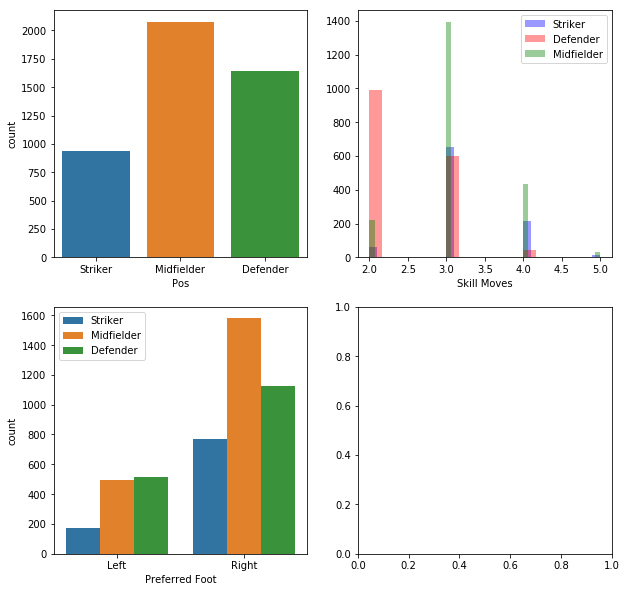

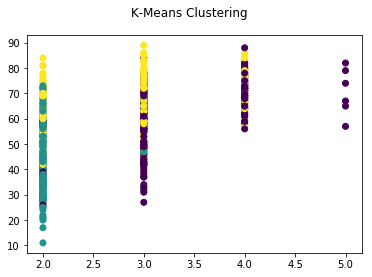

In [20]:
import pandas as pd, numpy as np, random, seaborn as sns
import sys
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble
from sklearn import feature_selection, model_selection, metrics
from sklearn.model_selection import train_test_split

fifa = pd.read_csv("./data.csv")

# remove unnecessary columns and players
df2 = fifa.loc[:, 'Crossing':'SlidingTackle']
df1 = fifa[['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Club', 'Value', 'Wage', 'Preferred Foot', 'Skill Moves', 'Position', 'Height', 'Weight', 'Release Clause']]
df = pd.concat([df1, df2], axis=1)
df = df.loc[df['Position'] != 'GK', :]

df = df.dropna()

# Cleanup functions

# convert string to int
def cleanValues(df_value):
    try:
        value = float(df_value[1:-1])
        suffix = df_value[-1:]

        if suffix == 'M':
            value = value * 1000000
        elif suffix == 'K':
            value = value * 1000
    except ValueError:
        value = 0
    return value

def cleanWeight(df_weight):
    return df_weight[:-3]

def cleanHeight(df_height):
    try:
        feet = int(df_height[0])
        dlm = df_height[-2]

        if dlm == "'":
            height = round((feet * 12 + int(df_height[-1])) * 2.54, 0)
        elif dlm != "'":
            height = round((feet * 12 + int(df_height[-2:])) * 2.54, 0)
    except ValueError:
        height = 0
    return height

# convert 100K to 100000 etc
df['Value_float'] = df['Value'].apply(cleanValues)
df['Wage_float'] = df['Wage'].apply(cleanValues)
df['Release_Clause_float'] = df['Release Clause'].apply(cleanValues)

# remove lbs suffix and convert to int
df['Weight_int'] = df['Weight'].apply(cleanWeight)
df['Weight_int'] = df['Weight_int'].apply(lambda x: int(x))

# convert from feet/inch to number
df['Height_int'] = df['Height'].apply(cleanHeight)

# Left = 1, Right = 0
df.loc[df['Preferred Foot'] == 'Left', 'Preferred_Foot'] = 1
df.loc[df['Preferred Foot'] == 'Right', 'Preferred_Foot'] = 0


# group various positions into 3 main categories/classes
for i in ['ST', 'CF', 'LF', 'LS', 'LW', 'RF', 'RS', 'RW']:
  df.loc[df.Position == i , 'Pos'] = 'Striker' 

for i in ['CAM', 'CDM', 'LCM', 'CM', 'LAM', 'LDM', 'LM', 'RAM', 'RCM', 'RDM', 'RM']:
  df.loc[df.Position == i , 'Pos'] = 'Midfielder' 

for i in ['CB', 'LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB']:
  df.loc[df.Position == i , 'Pos'] = 'Defender'

# remove original columns (we'll use processed ones)
df = df.drop(['Value', 'Wage', 'Release Clause', 'Weight', 'Height'], axis=1)

# only process players with rating >= 70
df = df[df['Overall'] >=70]

print('FIFA 19 Players Dataset')
print(df.head())
print(df.describe())

# plots
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False)

#plt.figure(figsize=(6, 4))
sns.countplot(x = 'Pos', data =df, ax=axes[0,0])

#plt.figure(figsize=(5,3))
a = df[df['Pos'] == 'Striker']
b = df[df['Pos'] == 'Defender']
c = df[df['Pos'] == 'Midfielder']
sns.distplot(a['Skill Moves'], color='blue', label = 'Striker', kde=False, ax=axes[0,1])
sns.distplot(b['Skill Moves'], color='red', label = 'Defender',  kde=False, ax=axes[0,1])
sns.distplot(c['Skill Moves'], color='green', label = 'Midfielder',  kde=False, ax=axes[0,1])
axes[0,1].legend()
#plt.figure(figsize=(5,3))
sns.countplot(x='Preferred Foot', data=df, hue='Pos', ax=axes[1,0])
axes[1,0].legend()

f.savefig('graph-df.png')

cols = ['Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'Weight_int', 'Height_int', 'Preferred_Foot']

# target class
y = ['Pos']
# input
x = cols
# split (80:20)
x_train, x_test, y_train, y_test = train_test_split(df[x],df[y], test_size=0.2)



classifiers = [
    ensemble.AdaBoostClassifier(),
    ensemble.RandomForestClassifier(n_estimators=10),
    linear_model.LogisticRegressionCV(multi_class='auto', cv=3, max_iter=800),
    neighbors.KNeighborsClassifier(),
    #svm.SVC(probability=True),
    svm.LinearSVC(),
    tree.DecisionTreeClassifier(),
]

# run 10 times with 60% training, 30% test data, rest 10% skipped
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

# to compare metrics
res_columns = ['Name','Train Accuracy', 'Test Accuracy', 'Time Taken']
res_compare = pd.DataFrame(columns = res_columns)
# to compare predictions
res_predict = y_train[y]

warnings.filterwarnings('ignore')


print('\nRunning: ', end='')
row_index = 1
for alg in classifiers:
    #set name and parameters
    res_name = alg.__class__.__name__
    print(res_name, end=', ')
    sys.stdout.flush()
    res_compare.loc[row_index, 'Name'] = res_name
    cv_results = model_selection.cross_validate(alg,x_train[x],  y_train[y].values.ravel(), cv  = cv_split, return_train_score=True)
    res_compare.loc[row_index, 'Time Taken'] = cv_results['fit_time'].mean()
    res_compare.loc[row_index, 'Train Accuracy'] = cv_results['train_score'].mean()
    res_compare.loc[row_index, 'Test Accuracy'] = cv_results['test_score'].mean()
    
    alg.fit(x_train[x],  y_train[y].values.ravel())
    res_predict[res_name] = alg.predict(x_train[x])    
    row_index+=1


# Sort
res_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)
print('\n')

# K-Means Clustering    
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(x_train)
kmeans_pred = kmeans.fit_predict(x_test)

f = plt.figure('kmeans')
f.suptitle('K-Means Clustering')
plt.scatter(x_test.values[:,0], x_test.values[:,1],c=kmeans_pred)
f.savefig('graph-kmeans.png')


res_compare.to_csv('predictions-summary.csv')
res_predict.to_csv('predictions-output.csv')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(res_compare)